In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
%matplotlib inline

In [ ]:
import os, sys
from google.colab import drive

drive.mount('/content/drive')
nb_path = '/content/drive/MyDrive/Colab Notebooks/site-packages'
sys.path.insert(0, nb_path)  # or append(nb_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!pip install --target=$'/content/drive/MyDrive/Colab Notebooks/site-packages' mxnet-cu101

In [ ]:
#!pip install --target='/content/drive/MyDrive/Colab Notebooks/site-packages' gluonts

In [ ]:
datapath = '/content/drive/MyDrive/Colab Notebooks/태양열 발전량 예측'
trainpath = datapath + '/train/train.csv'
testpath = datapath + '/test' # 여러개 csv 파일 존재함
samplepath = datapath + '/sample_submission.csv'

train_org = pd.read_csv(trainpath, index_col=0)

In [ ]:
sample = pd.read_csv(samplepath)

## timestamp 찍어서 인덱스로 넣기

In [ ]:
from itertools import accumulate


def find_month(day):
    month_table = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    month_table = list(accumulate(map(int, month_table)))
    # [31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365]
    day = (day % 365) + 1
    if day <= 181: # 6까지
        idx = 0

        while idx < 5:
            if day > month_table[idx]:
                idx += 1

            else:
                break

        return idx+1

    else:
        idx = 6

        while idx < 11:
            if day > month_table[idx]:
                idx += 1

            else:
                break

        return idx+1


def set_days(df):
    month_table = [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31] # 보편적인 1년의 일 수 그냥 넣음
    month_table = list(accumulate(map(int, month_table))) # 누적하기
    copied = df.copy()
    copied['Day'] = (copied['Day'] % 365) + 1
    modifed = []

    for i, v in enumerate(month_table):
        if i > 0:
            temp = copied[copied['Month'] == i].copy()
            temp['Day'] = temp['Day'] - month_table[i-1]
            modifed.append(temp)

    return pd.concat(modifed)

In [ ]:
df = train_org.reset_index()
df['Year'] = df['Day'] / 365 + 2016  # 그냥 Timestamp 찍기 위한 가정임.
df['Year'] = df['Year'].apply(lambda x: int(x))
df['Month'] = df['Day'].apply(find_month)
df = set_days(df)

def to_str(y, mo, d, h, m):
    mo = str(int(mo)).zfill(2)
    d = str(int(d)).zfill(2)
    h = str(int(h)).zfill(2)
    m = str(int(m)).zfill(2)

    temp = f'{int(y)}-{mo}-{d} {h}:{m}:00'
    return temp

df['Timestamp'] = df.apply(lambda row : to_str(row['Year'], row['Month'], row['Day'], row['Hour'], row['Minute']), axis=1)
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.sort_values('Timestamp')

In [ ]:
df.to_csv("/content/drive/MyDrive/ColabNotebooks/태양열 발전량 예측/Timestamped.csv", index=False)

# MQ-RNN

방법:



1.   시계열 데이터로 접근하여 Timestamp와 Target 값만 가져와 학습시킴. Target 값 자체가 주기성과 계절성이 뚜렷하기 때문에 가능함.
2.   MQ-RNN Encoder로 값을 넣기 전에 NN을 추가해 원본 데이터가 다양한 피처를 조합해서 값을 가지도록 한 후, 해당 NN의 결과값을 MQ-RNN 인코더에 넣는 방법.






In [ ]:
import os, sys
from google.colab import drive

drive.mount('/content/drive')
nb_path = '/content/drive/MyDrive/Colab Notebooks/site-packages'
sys.path.insert(0, nb_path)  # or append(nb_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/태양열 발전량 예측/Timestamped.csv")
df['Timestamp'] = pd.to_datetime(df['Timestamp']) # load하면 또 다시 변환해줘야 함
df

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,Year,Month,Timestamp
0,1,0,0,0,0,1.5,69.08,-12,0.0,2016,1,2016-01-01 00:00:00
1,1,0,30,0,0,1.5,69.06,-12,0.0,2016,1,2016-01-01 00:30:00
2,1,1,0,0,0,1.6,71.78,-12,0.0,2016,1,2016-01-01 01:00:00
3,1,1,30,0,0,1.6,71.75,-12,0.0,2016,1,2016-01-01 01:30:00
4,1,2,0,0,0,1.6,75.20,-12,0.0,2016,1,2016-01-01 02:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
52555,31,21,30,0,0,2.4,70.70,-4,0.0,2018,12,2018-12-31 21:30:00
52556,31,22,0,0,0,2.4,66.79,-4,0.0,2018,12,2018-12-31 22:00:00
52557,31,22,30,0,0,2.2,66.78,-4,0.0,2018,12,2018-12-31 22:30:00
52558,31,23,0,0,0,2.1,67.72,-4,0.0,2018,12,2018-12-31 23:00:00


In [ ]:
df = df.set_index(df['Timestamp'])
train_end = pd.to_datetime('2018-12-22 23:30:00') # 데이터 커져서 커널이 자꾸 죽어서 축소시킴. 6 개월치의 데이터만 사용하도록 함
valid_start = pd.to_datetime('2018-12-23 00:00:00')
train = df.loc[:train_end, ['TARGET', 'DHI', 'DNI', 'RH', 'T']]
valid = df.loc[valid_start:, ['TARGET', 'DHI', 'DNI', 'RH', 'T']]

In [ ]:
from gluonts.dataset.common import ListDataset

prediction_window = 96 # 고정적으로 이틀치를 예측하도록 함

train_ds = ListDataset( # 4일전까지를 학습하고
    [{"start": train.index[0],
      "target": train.TARGET.values[:-prediction_window],
      'feat_dynamic_real' : [train.DHI.values[:-prediction_window],
                          train.DNI.values[:-prediction_window],
                          train.RH.values[:-prediction_window],
                          train['T'].values[:-prediction_window]]
      }],
    freq = "30min"
)

valid_ds = ListDataset(
    [{
        "start": valid.index[0],
        "target": valid.TARGET.values[:-prediction_window],
        'feat_dynamic_real' : [valid.DHI.values[:-prediction_window],
                        valid.DNI.values[:-prediction_window],
                        valid.RH.values[:-prediction_window],
                        valid['T'].values[:-prediction_window]]
      
      }],
    freq = "30min"
)

In [ ]:
'''from gluonts.dataset.field_names import FieldName
from gluonts.dataset.common import ListDataset

train_ds = ListDataset([{FieldName.TARGET: target, 
                         FieldName.START: start,
                         FieldName.FEAT_DYNAMIC_REAL: [fdr]}
                        for (target, start, fdr) in zip(temp.TARGET[:-prediction_window].values, 
                                                             start_time, 
                                                             feat_dynamic_real[:-prediction_window].values)],
                      freq='30min')'''

"from gluonts.dataset.field_names import FieldName\nfrom gluonts.dataset.common import ListDataset\n\ntrain_ds = ListDataset([{FieldName.TARGET: target, \n                         FieldName.START: start,\n                         FieldName.FEAT_DYNAMIC_REAL: [fdr]}\n                        for (target, start, fdr) in zip(temp.TARGET[:-prediction_window].values, \n                                                             start_time, \n                                                             feat_dynamic_real[:-prediction_window].values)],\n                      freq='30min')"

In [ ]:
from gluonts.model.seq2seq import MQRNNEstimator
from gluonts.mx.trainer import Trainer

freq = "30min"
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

estimator = MQRNNEstimator(prediction_length=prediction_window, 
                           freq=freq, 
                           quantiles=quantiles,
                           trainer=Trainer(epochs=10, batch_size=32, ctx = mx.context.gpu()))

predictor = estimator.train(training_data=train_ds
                            #, validation_data=valid
                            )

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:06<00:00,  7.82it/s, epoch=10/10, avg_epoch_loss=0.0985]


In [ ]:
from gluonts.evaluation.backtest import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=valid_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [ ]:
forecasts = list(forecast_it)
tss = list(ts_it)

forecast_entry = forecasts[0]
ts_entry = tss[0]

In [ ]:
# print(f"Number of sample paths: {forecast_entry.num_samples}")
# print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Start date of the forecast window: 2018-12-28 00:00:00
Frequency of the time series: 30min


In [ ]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 48*4
    # prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] # + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    # forecast_entry.plot(color='g', ax=ax)
    temp = pd.DataFrame(forecast_entry.forecast_array.transpose(), index=ts_entry.index[-forecast_entry.prediction_length:], columns=forecast_entry.forecast_keys).plot(ax=ax, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

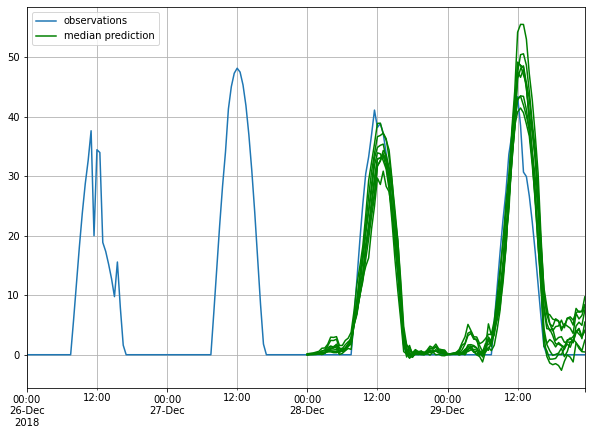

In [ ]:
plot_prob_forecasts(ts_entry, forecast_entry) # epoch 5

In [ ]:
prediction = next(predictor.predict(train))

prediction = next(predictor.predict(train)) # type(prediction) => QuantileForecast class

prediction.forecast_array => (num_quantiles, forecast values for predicition windows)

따라서 이번 예제에서 forecast_array는 (9, 96)의 shape을 가진다.

In [ ]:
from gluonts.evaluation.backtest import make_evaluation_predictions

test_data = ListDataset(
    [{"start": temp.index[0], "target": temp.TARGET.values}],
    freq = "30min"
)
# test_data의 target 시간 이후부터 예측을 실행하는 것으로 보임. train과 test는 무슨 연관이 있는 것인가 그러면?

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [ ]:
forecasts = list(forecast_it)
tss = list(ts_it)

forecast_entry = forecasts[0]
ts_entry = tss[0]

In [ ]:
# print(f"Number of sample paths: {forecast_entry.num_samples}")
# print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Start date of the forecast window: 2018-12-29 00:00:00
Frequency of the time series: 30min


In [ ]:
new_ary = []

for ary in forecast_entry.forecast_array:
    ary = np.where(ary <0, 0, ary)
    new_ary.append(ary)

forecast_entry.forecast_array = np.array(new_ary)

In [ ]:
pd.DataFrame(forecast_entry.forecast_array.transpose())

,0,1,2,3,4,5,6,7,8
0,0.269632,0.457640,0.434057,0.647847,1.560288,1.620001,1.860057,2.392335,2.536002
1,0.499269,0.591494,0.302545,1.093298,1.553852,1.986579,2.192621,2.720931,2.249751
2,0.628407,0.822227,0.603191,1.158305,1.972452,2.226515,2.757081,3.644567,2.387721
3,0.290450,0.918674,0.923385,1.368202,2.329176,2.099648,3.043955,4.142349,2.600474
4,0.663518,1.219584,1.768284,1.822532,2.762099,2.462594,3.546255,4.595234,3.126234
...,...,...,...,...,...,...,...,...,...
91,0.119846,0.299270,0.414431,0.082710,0.002868,0.213356,0.492890,0.892344,0.495349
92,0.592810,0.730253,0.566934,0.604504,0.602223,0.720347,1.168180,1.653026,1.432525
93,0.464157,0.113364,0.084476,0.477775,1.180083,0.993950,0.966325,1.739074,1.494264
94,0.281802,0.251896,0.370075,0.603392,1.617511,1.224970,1.443429,2.213345,1.792599


In [ ]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 48*4
    # prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] # + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    # forecast_entry.plot(color='g', ax=ax)
    temp = pd.DataFrame(forecast_entry.forecast_array.transpose(), index=ts_entry.index[-forecast_entry.prediction_length:], columns=forecast_entry.forecast_keys).plot(ax=ax, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

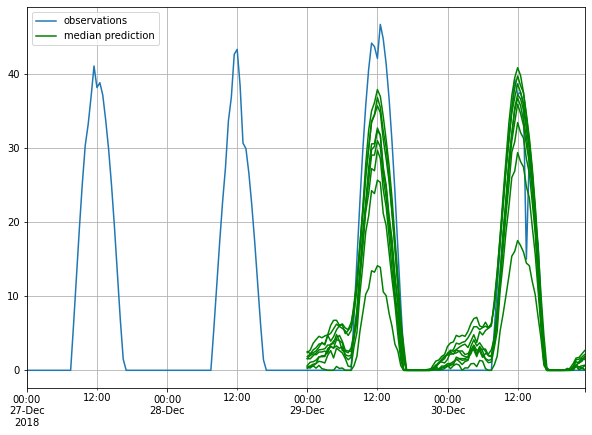

In [ ]:
plot_prob_forecasts(ts_entry, forecast_entry) # epoch 5

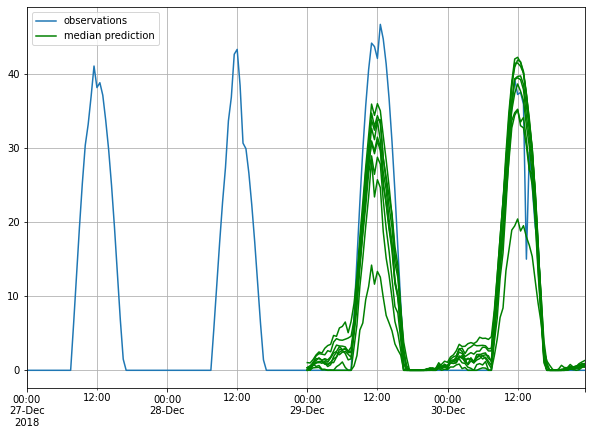

In [ ]:
plot_prob_forecasts(ts_entry, forecast_entry) # epoch 10

In [ ]:
from gluonts.evaluation import Evaluator

evaluator = Evaluator(quantiles=quantiles)

agg_metrics, item_metrics = evaluator(ts_it, forecast_it)

In [ ]:
def pinball_loss(y_true, quantile_forecast, quantiles):
    total = 0
    for quantile, pred in zip(quantiles, quantile_forecast):
        if y_true >= pred:
            total += (y_true - pred) * quantile

        else:
            total += (1-quantile) * (pred - y_true)

    return total / len(quantiles)